## **SALES FORECASTING MODEL**

The objective of this model is to forecast the sales of individual products across the country. 

| ***The Data Dictionary*** |  |
| --------------------------- |----|
| **Column Name** | **Description** |
| *Target* | the total sales for a product category at a particular store at a given date |
| *Stores_id* | the unique store id |
| *Category_id* | the unique Product category id |
| *Date* | date in numerical representation |
| *Onpromotion* | gives the total number of items in a Product category that were being promoted at a store at a given date |
| *Nbr_of_transactions* | the total number of transactions happened at a store at a given date |
| *year_weekofyear* | the combination of the year and the week of the year, (year_weekofyear = year*100+week_of_year) |
| *ID* | the unique identifier for each row in the testing set: year_week_{year_weekofyear}_{store_id}_{Category_id} |


In [1]:
# Importation
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
#read the data
df = pd.read_csv('../Data/train.csv')
df.dtypes

date                    object
store_id                object
category_id             object
target                 float64
onpromotion              int64
nbr_of_transactions      int64
dtype: object

In [3]:
#change date column to datetime
df['date'] = pd.to_datetime(df['date'])
df

,date,store_id,category_id,target,onpromotion,nbr_of_transactions
0,1900-12-30,store_1,category_24,0.00000,0,0
1,1900-12-30,store_1,category_21,0.00000,0,0
2,1900-12-30,store_1,category_32,0.00000,0,0
3,1900-12-30,store_1,category_18,0.00000,0,0
4,1900-12-30,store_1,category_26,0.00000,0,0
...,...,...,...,...,...,...
1048570,1902-08-10,store_3,category_23,929.36597,0,2953
1048571,1902-08-10,store_3,category_20,274.99300,0,2953
1048572,1902-08-10,store_3,category_15,6492.75600,0,2953
1048573,1902-08-10,store_3,category_29,1.00000,0,2953


In [43]:
start_date = df.date.min()
end_date = df.date.max()
date_range = pd.date_range(start=start_date, end= end_date, freq='D')
date_range
missing_date = date_range.difference(df.date)
missing_date

DatetimeIndex([], dtype='datetime64[ns]', freq='D')

There is no missing data in this dataset

considering target is our sales per product, we can aggregate on date and product to have higher volume to forecast.

In [35]:
df['date'].max() - df['date'].min()

Timedelta('588 days 00:00:00')

In [61]:
agg_data = df.groupby(['date','category_id']).sum().reset_index().set_index('date')
agg_data

,category_id,store_id,target,onpromotion,nbr_of_transactions
date,,,,,
1900-12-30,category_0,store_1store_10store_11store_12store_13store_1...,33.000,0,1327
1900-12-30,category_1,store_1store_10store_11store_12store_13store_1...,2.000,0,1327
1900-12-30,category_10,store_1store_10store_11store_12store_13store_1...,3.000,0,1327
1900-12-30,category_11,store_1store_10store_11store_12store_13store_1...,2.000,0,1327
1900-12-30,category_12,store_1store_10store_11store_12store_13store_1...,160.157,0,1327
...,...,...,...,...,...
1902-08-10,category_5,store_1store_10store_11store_12store_13store_1...,4.000,0,29069
1902-08-10,category_6,store_1store_10store_11store_12store_13store_1...,18.000,0,29069
1902-08-10,category_7,store_1store_10store_11store_12store_13store_1...,58812.754,109,29069


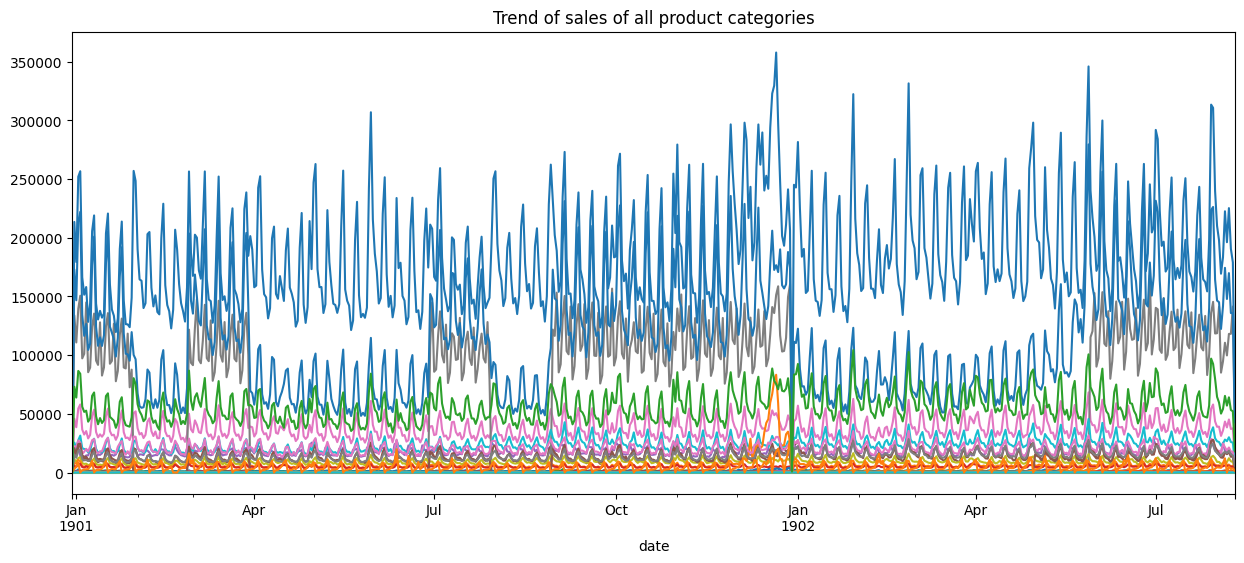

In [109]:
#check trend of all product categories 
for item in agg_data['category_id'].unique():
    data = agg_data[agg_data['category_id'] == item]['target']
    data.plot(figsize=(15,6))
plt.title('Trend of sales of all product categories')
plt.show()

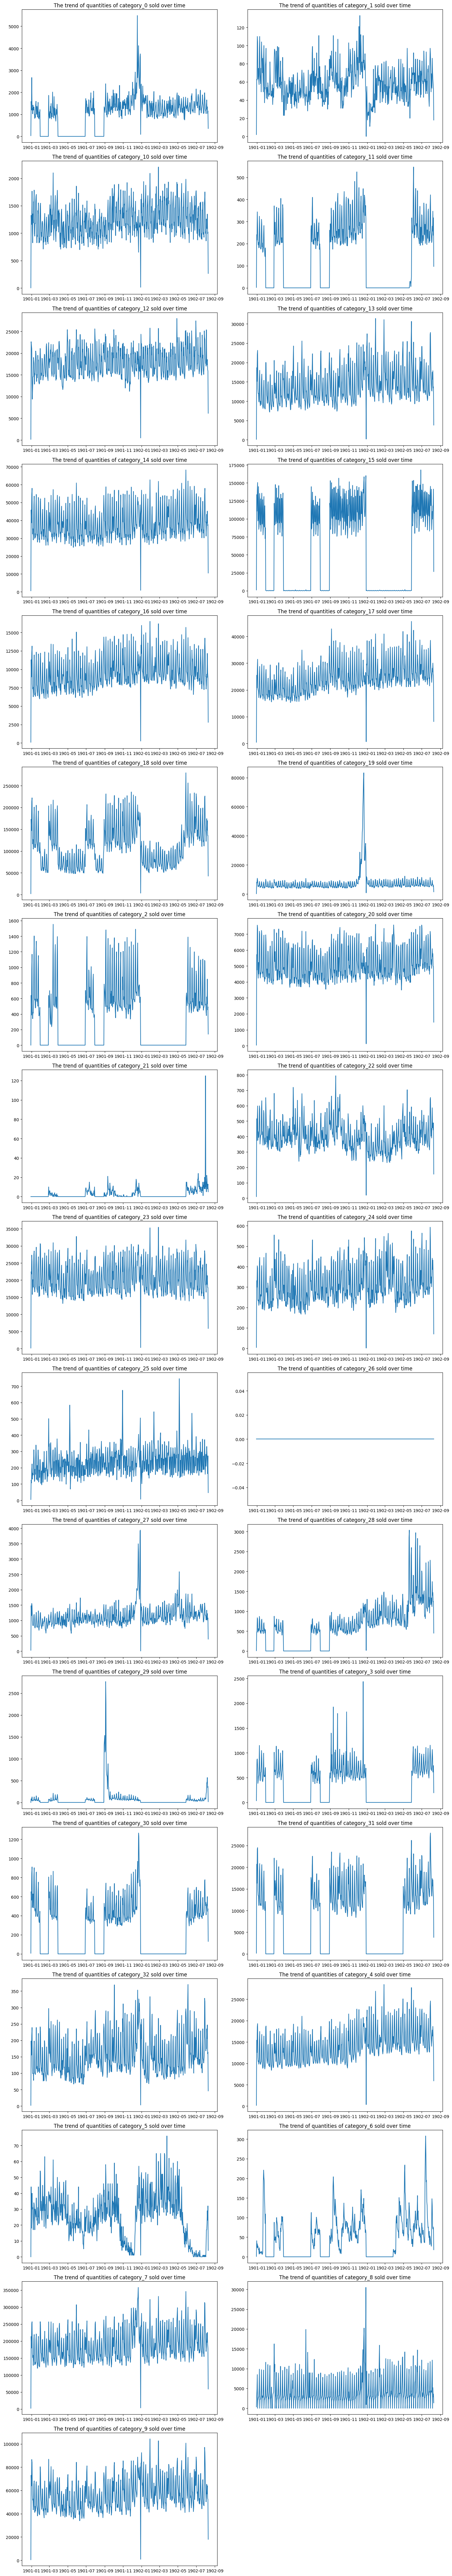

In [64]:
# Number of unique categories
unique_categories = agg_data['category_id'].unique()
num_categories = len(unique_categories)

# Determine the number of rows needed for the subplots
ncols = 2
nrows = (num_categories + ncols - 1) // ncols  # Ceiling division

# Create the subplots
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 5 * nrows))

# Flatten the axs array for easy iteration
axs = axs.flatten()

# Plot each category in its own subplot
for i, item in enumerate(unique_categories):
    data = agg_data[agg_data['category_id'] == item]['target']
    axs[i].plot(data)
    axs[i].set_title(f'The Quantities of {item} sold over time')

# Hide any empty subplots
for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()

All product categories have unique trendlines and would need to be forecasted individually to ensure accuracy in the forecast. 
We will first try out category 9.

In [53]:
agg_data[agg_data['category_id'] == 'category_9'].drop(columns='category_id')

,date,store_id,target,onpromotion,nbr_of_transactions
32,1900-12-30,store_1store_10store_11store_12store_13store_1...,456.0,0,1327
65,1900-12-31,store_1store_10store_11store_12store_13store_1...,73045.0,0,90716
98,1901-01-01,store_1store_10store_11store_12store_13store_1...,63840.0,0,84488
131,1901-01-02,store_1store_10store_11store_12store_13store_1...,86517.0,0,101361
164,1901-01-03,store_1store_10store_11store_12store_13store_1...,84114.0,0,93475
...,...,...,...,...,...
19304,1902-08-06,store_1store_10store_11store_12store_13store_1...,56966.0,85,79233
19337,1902-08-07,store_1store_10store_11store_12store_13store_1...,64049.0,73,87127
19370,1902-08-08,store_1store_10store_11store_12store_13store_1...,53217.0,77,82118
19403,1902-08-09,store_1store_10store_11store_12store_13store_1...,52148.0,82,82224


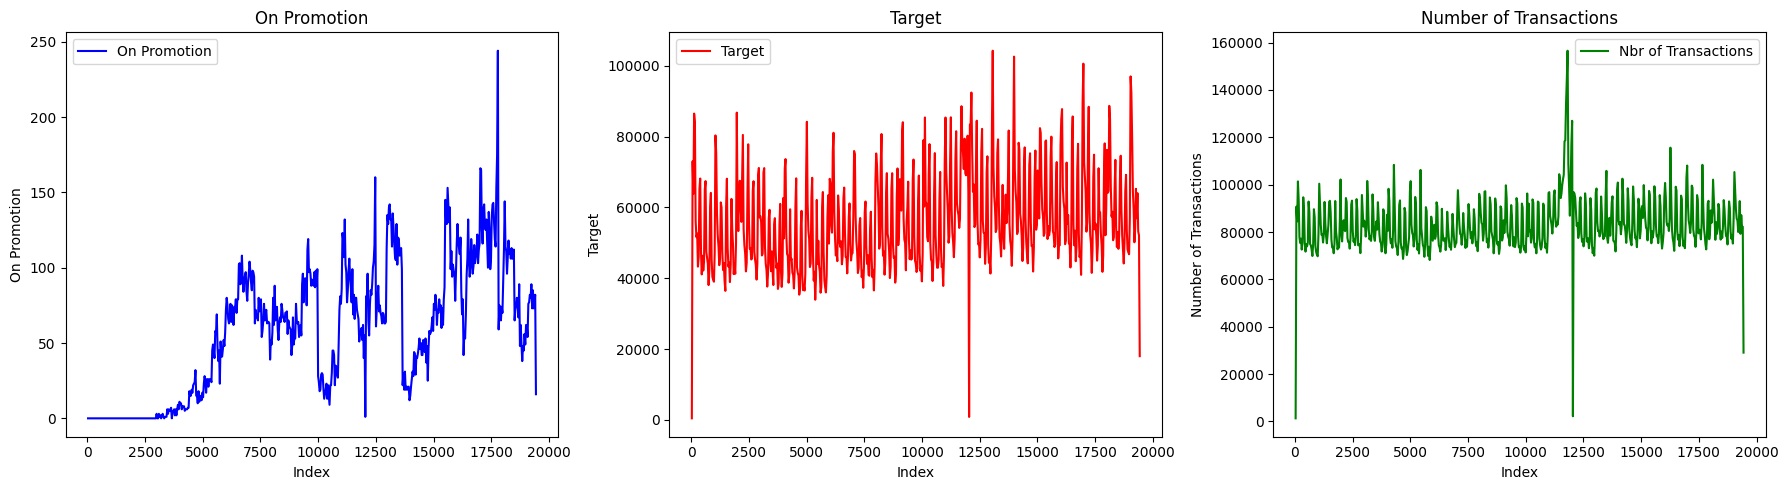

In [60]:
# Filter data for category_9
category_9_data = agg_data[agg_data['category_id'] == 'category_9'].drop(columns='category_id')

# Create subplots
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(18, 5))

# Plot 'onpromotion'
axs[0].plot(category_9_data.index, category_9_data['onpromotion'], label='On Promotion', color='b')
axs[0].set_title('On Promotion')
axs[0].set_xlabel('Index')
axs[0].set_ylabel('On Promotion')
axs[0].legend()

# Plot 'target'
axs[1].plot(category_9_data.index, category_9_data['target'], label='Target', color='r')
axs[1].set_title('Target')
axs[1].set_xlabel('Index')
axs[1].set_ylabel('Target')
axs[1].legend()

# Plot 'nbr_of_transactions'
axs[2].plot(category_9_data.index, category_9_data['nbr_of_transactions'], label='Nbr of Transactions', color='g')
axs[2].set_title('Number of Transactions')
axs[2].set_xlabel('Index')
axs[2].set_ylabel('Number of Transactions')
axs[2].legend()

plt.tight_layout()
plt.show()

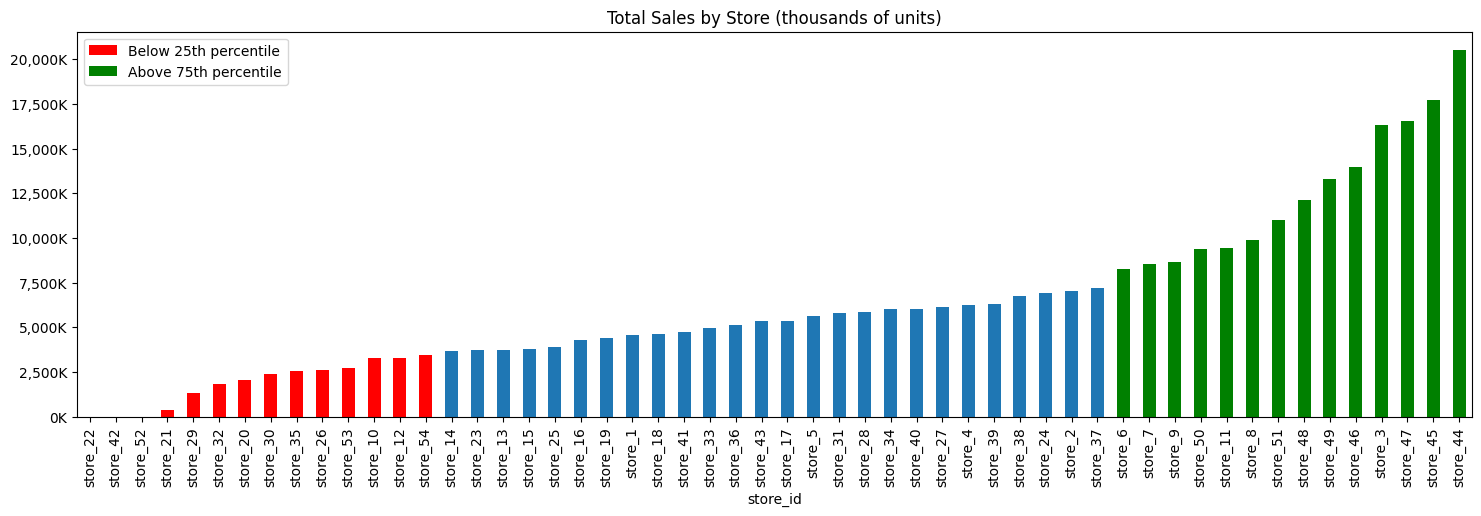

In [97]:
# Chec# Checking total store sales over the period
df_sales = df[['store_id','target']].groupby('store_id').sum().sort_values(by='target')

# Calculate percentile data
percentiles = df_sales['target'].quantile([0.25, 0.5, 0.75])

# Plot sales data
ax = df_sales.plot(kind='bar', figsize=(18,5), title='Total Sales by Store (thousands of units)')

# Set bar colors
for i, bar in enumerate(ax.patches):
    if df_sales.iloc[i]['target'] < percentiles[0.25]:
        bar.set_facecolor('red')
    elif df_sales.iloc[i]['target'] > percentiles[0.75]:
        bar.set_facecolor('green')

# Create proxy artists for legend
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

legend_elements = [
    Patch(facecolor='red', label='Below 25th percentile'),
    Patch(facecolor='green', label='Above 75th percentile')
]

# Add legend
import matplotlib.pyplot as plt
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x/1000)) + 'K'))
ax.legend(handles=legend_elements, loc='upper left')
plt.show()

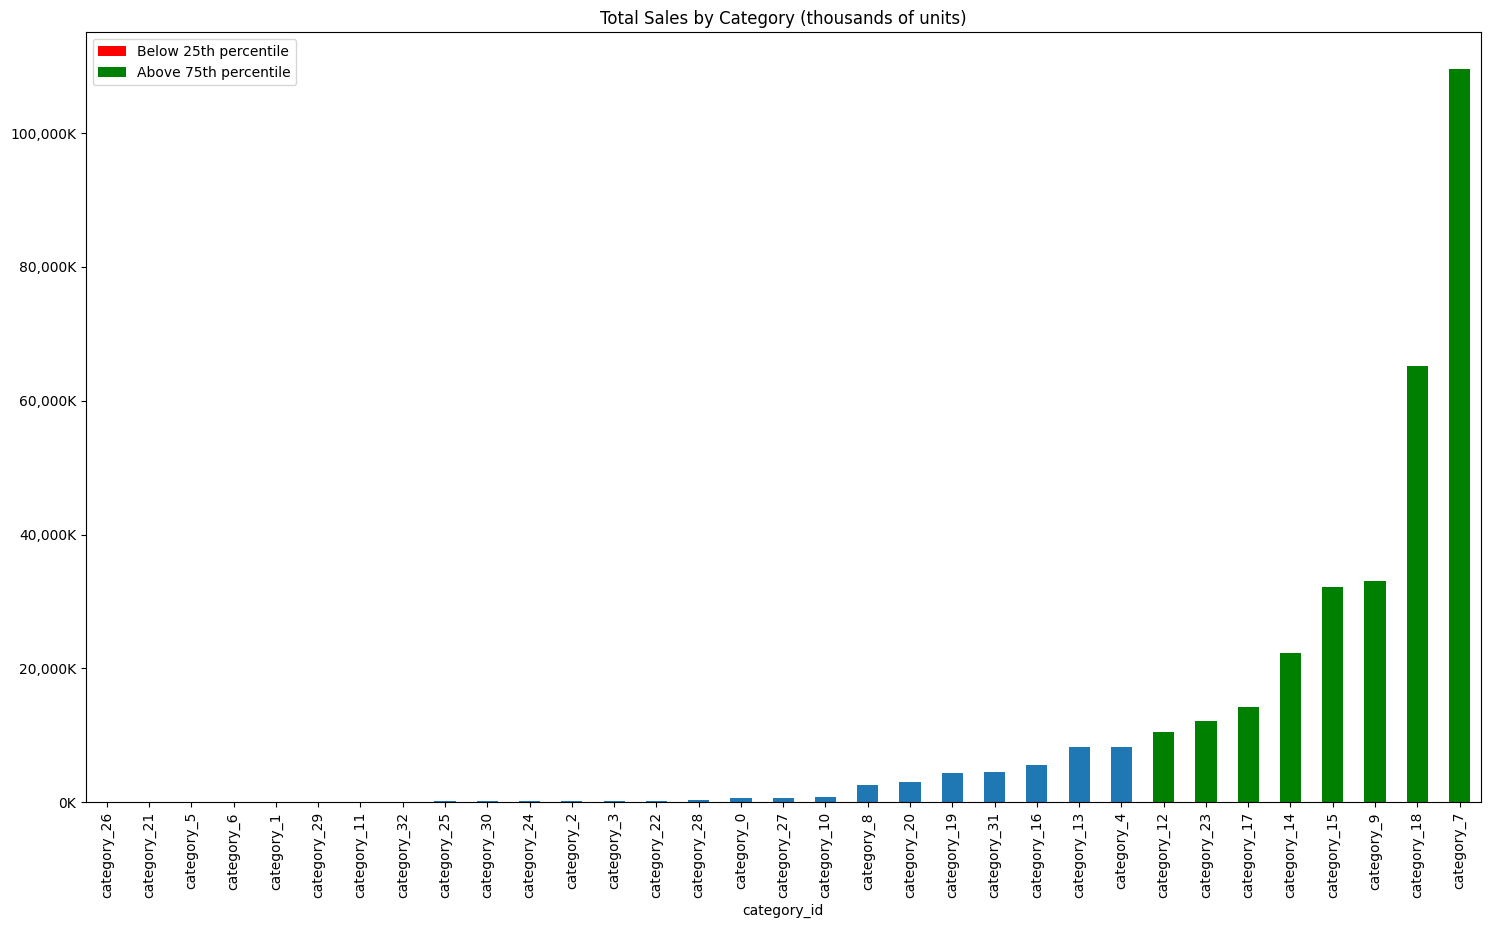

In [99]:
# Check Checking total store sales over the period
df_sales = df[['category_id','target']].groupby('category_id').sum().sort_values(by='target')

# Calculate percentile data
percentiles = df_sales['target'].quantile([0.25, 0.5, 0.75])

# Plot sales data
ax = df_sales.plot(kind='bar', figsize=(18,10), title='Total Sales by Category (thousands of units)')

# Set bar colors
for i, bar in enumerate(ax.patches):
    if df_sales.iloc[i]['target'] < percentiles[0.25]:
        bar.set_facecolor('red')
    elif df_sales.iloc[i]['target'] > percentiles[0.75]:
        bar.set_facecolor('green')

# Create proxy artists for legend
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

legend_elements = [
    Patch(facecolor='red', label='Below 25th percentile'),
    Patch(facecolor='green', label='Above 75th percentile')
]

# Add legend
import matplotlib.pyplot as plt
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x/1000)) + 'K'))
ax.legend(handles=legend_elements, loc='upper left')
plt.show()

* There are three stores, 22, 42 and 52, that have no sales across the whole period. 
* There are 51 stores with sales across the period.

In [68]:
# aggregate by stores and check trend
df.drop(columns='category_id').groupby(['date','store_id']).sum().reset_index()

,date,store_id,target,onpromotion,nbr_of_transactions
0,1900-12-30,store_1,0.000000,0,0
1,1900-12-30,store_10,0.000000,0,0
2,1900-12-30,store_11,0.000000,0,0
3,1900-12-30,store_12,0.000000,0,0
4,1900-12-30,store_13,0.000000,0,0
...,...,...,...,...,...
31770,1902-08-10,store_26,2659.141999,14,14784
31771,1902-08-10,store_27,9977.189000,24,45210
31772,1902-08-10,store_28,9644.509008,34,34221
31773,1902-08-10,store_29,8091.804000,35,32901


<Axes: xlabel='date'>

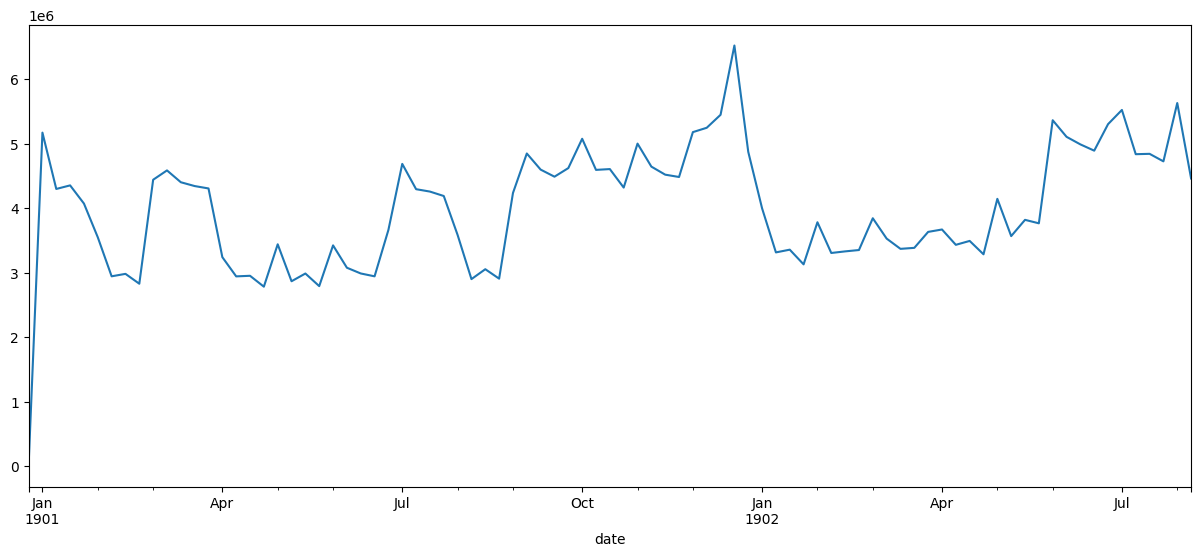

In [113]:
df.set_index('date').resample('W').sum().drop(columns=['store_id','category_id'])['target'].plot(figsize=(15,6))

In [136]:
#Grouped by category_id
category = df.drop(columns='store_id').groupby(['date','category_id']).sum().reset_index().set_index('date')

In [135]:
#grouped by store_id
store = df.drop(columns='category_id').groupby(['date','store_id']).sum().reset_index().set_index('date')

In [134]:
#resample data to weekly
week = df.set_index('date').resample('W').sum().drop(columns='store_id').reset_index()

In [139]:
df.set_index('date').drop(columns=['category_id','store_id']).resample('W').mean()

,target,onpromotion,nbr_of_transactions
date,,,
1900-12-30,4.827197,0.000000,24.574074
1901-01-06,414.448273,0.000000,1588.330688
1901-01-13,344.448125,0.000000,1465.534392
1901-01-20,348.886261,0.000000,1461.484127
1901-01-27,326.286563,0.000000,1418.518519
...,...,...,...
1902-07-13,387.659947,1.829806,1529.531746
1902-07-20,388.103846,1.922238,1531.685185
1902-07-27,378.749738,2.077040,1529.410053
